The following factorial (Example 6-2 in the text) was used to investigate the effects of four factors on the filtration rate of a resin for a chemical process plant. The factors are A = temperature, B = pressure, C = mole ratio (concentration of chemical formaldehyde), D = stirring rate. This experiment was performed in a pilot plant.

The parameter ranges are:
- A: 20-40 C 
- B: 1-1.2 bar
- C: 0.3-0.6 %
- D: 1000-1300 rpm  


Make a factorial design and make a model with as few contrasts as possible form the data in [Ex6-2.csv](/Week_2/Lab_1/Task_1/Ex6-2.csv).

In [72]:
#Import all packages 
import pandas as pd
import numpy as np
from numpy.random import rand
import itertools
from matplotlib.pyplot import *
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [27]:
# create dictionary for parameters
input_labels = {
    'A' : 'Temperature',
    'B' : 'Pressure',
    'C' : 'Mole ratio',
    'D' : 'Stirring rate [rpm]'
}

# create list of data for high and low. 
data = [
    ('A',20,40),
    ('B',1,1.2),
    ('C',0.3,0.6),
    ('D',1000,1300)
]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(data,columns=['index', 'low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : input_labels[z] )

#print dataframe
inputs_df

,low,high,label
index,,,
A,20.0,40.0,Temperature
B,1.0,1.2,Pressure
C,0.3,0.6,Mole ratio
D,1000.0,1300.0,Stirring rate [rpm]


Encode the raw data:

In [28]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,high,label,encoded_low,encoded_high
index,,,,,
A,20.0,40.0,Temperature,-1.0,1.0
B,1.0,1.2,Pressure,-1.0,1.0
C,0.3,0.6,Mole ratio,-1.0,1.0
D,1000.0,1300.0,Stirring rate [rpm],-1.0,1.0


Create the design matrix for the experiment

In [29]:
encoded_inputs= list(itertools.product([-1,1],[-1,1],[-1,1],[-1,1]))
encoded_inputs

results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B','C', 'D']
results

,A,B,C,D
0,-1,-1,-1,-1
1,1,-1,-1,-1
2,-1,1,-1,-1
3,1,1,-1,-1
4,-1,-1,1,-1
5,1,-1,1,-1
6,-1,1,1,-1
7,1,1,1,-1
8,-1,-1,-1,1
9,1,-1,-1,1


In [30]:
#Translates the desing matrix into the experimental matrix 
#where we can see what experiments we need to do for a full factorial

real_experiment = results

var_labels = []
for var in ['A','B','C', 'D']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else inputs_df.loc[var]['high'] , 
        axis=1)

print("The values of each real variable in the experiment are:")
real_experiment[var_labels]

The values of each real variable in the experiment are:


,Temperature,Pressure,Mole ratio,Stirring rate [rpm]
0,20.0,1.0,0.3,1000.0
1,40.0,1.0,0.3,1000.0
2,20.0,1.2,0.3,1000.0
3,40.0,1.2,0.3,1000.0
4,20.0,1.0,0.6,1000.0
5,40.0,1.0,0.6,1000.0
6,20.0,1.2,0.6,1000.0
7,40.0,1.2,0.6,1000.0
8,20.0,1.0,0.3,1300.0
9,40.0,1.0,0.3,1300.0


In [32]:
#Add the experimental results
exp_output = pd.read_csv('Ex6-2.csv', sep=',')

Exp_Rates = exp_output['Rate']

results['Rate']= Exp_Rates
results

,A,B,C,D,Temperature,Pressure,Mole ratio,Stirring rate [rpm],Rate
0,-1,-1,-1,-1,20.0,1.0,0.3,1000.0,45
1,1,-1,-1,-1,40.0,1.0,0.3,1000.0,71
2,-1,1,-1,-1,20.0,1.2,0.3,1000.0,48
3,1,1,-1,-1,40.0,1.2,0.3,1000.0,65
4,-1,-1,1,-1,20.0,1.0,0.6,1000.0,68
5,1,-1,1,-1,40.0,1.0,0.6,1000.0,60
6,-1,1,1,-1,20.0,1.2,0.6,1000.0,80
7,1,1,1,-1,40.0,1.2,0.6,1000.0,65
8,-1,-1,-1,1,20.0,1.0,0.3,1300.0,43
9,1,-1,-1,1,40.0,1.0,0.3,1300.0,100


Now all the data is formatted and design matrix done. Time to calculate the effects. Starting with the main effects. 

In [37]:
#Main effects

# Compute the mean effect of the factor on the response,
# conditioned on each variable
labels = ['A','B','C','D']

main_effects = {}

print('main effects')
for key in labels:
        average_effects = results.groupby(key)['Rate'].mean()
        main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(main_effects)

#main effects are: 'A': 21.625, 'B': 3.125, 'C': 9.875, 'D': 14.625
#All parameters looks like they have an effect, foremost A and D. 

main effects
{'A': 21.625, 'B': 3.125, 'C': 9.875, 'D': 14.625}


In [38]:
#Secondary effects
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:
    
    effects = results.groupby([key[0],key[1]])['Rate'].mean()
    
    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects


{('A', 'B'): 0.125,
 ('A', 'C'): -18.125,
 ('A', 'D'): 16.625,
 ('B', 'C'): 2.375,
 ('B', 'D'): -0.375,
 ('C', 'D'): -1.125}

The twoway effects that seem to be important are A-C and A-D. 

Now onto the 3-way interactions:

In [39]:
#3-way effect
threeway_labels = list(itertools.combinations(labels, 3))

threeway_effects = {}
for key in threeway_labels:
    
    effects = results.groupby([key[0],key[1],key[2]])['Rate'].mean()
    
    threeway_effects[key] = sum([ i*j*k*effects[i][j][k]/4 for i in [-1,1] for j in [-1,1] for k in [-1,1] ])

threeway_effects

{('A', 'B', 'C'): 1.875,
 ('A', 'B', 'D'): 4.125,
 ('A', 'C', 'D'): -1.625,
 ('B', 'C', 'D'): -2.625}

If any, the A-B-D interaction gives the largest (but small) effect. For the one 4-way effect we have:

In [62]:
#4-way effect
fourway_labels = list(itertools.combinations(labels, 4))

fourway_effects = {}
for key in fourway_labels:
    
    effects = results.groupby([key[0],key[1],key[2],key[3]])['Rate'].mean()
    
    fourway_effects[key] = sum([ i*j*k*l*effects[i][j][k][l]/8 for i in [-1,1] for j in [-1,1] for k in [-1,1] for l in [-1,1] ])

fourway_effects

#Fourway effect is: {('A', 'B', 'C', 'D'): 1.375}

{('A', 'B', 'C', 'D'): 1.375}

In [56]:
#Make a list of all the effects in absolute value

effects=[] #creates an empty pd.DataFrame({})
indexes=[]
for i,k in enumerate(main_effects.keys()):
    effects.append(abs(main_effects[k]))
    indexes.append(k)
for i,k in enumerate(twoway_effects.keys()):
    effects.append(abs(twoway_effects[k]))
    indexes.append(k)
for i,k in enumerate(threeway_effects.keys()):
    effects.append(abs(threeway_effects[k]))
    indexes.append(k)    
    
effects_df=pd.DataFrame({"Standardized effect":effects})

# reset the indexes
effects_df.index=indexes
# Sort values in descending order
effects_df = effects_df.sort_values(by='Standardized effect', ascending=False)
# Add cumulative percentage column
effects_df["cum_percentage"] = round(effects_df["Standardized effect"].cumsum()/effects_df["Standardized effect"].sum()*100,2)

# Display data frame of the effects
effects_df

,Standardized effect,cum_percentage
A,21.625,22.01
"(A, C)",18.125,40.46
"(A, D)",16.625,57.38
D,14.625,72.26
C,9.875,82.32
"(A, B, D)",4.125,86.51
B,3.125,89.69
"(B, C, D)",2.625,92.37
"(B, C)",2.375,94.78
"(A, B, C)",1.875,96.69


To evaluate/see the effects more clearly a pareto graph can be plotted:

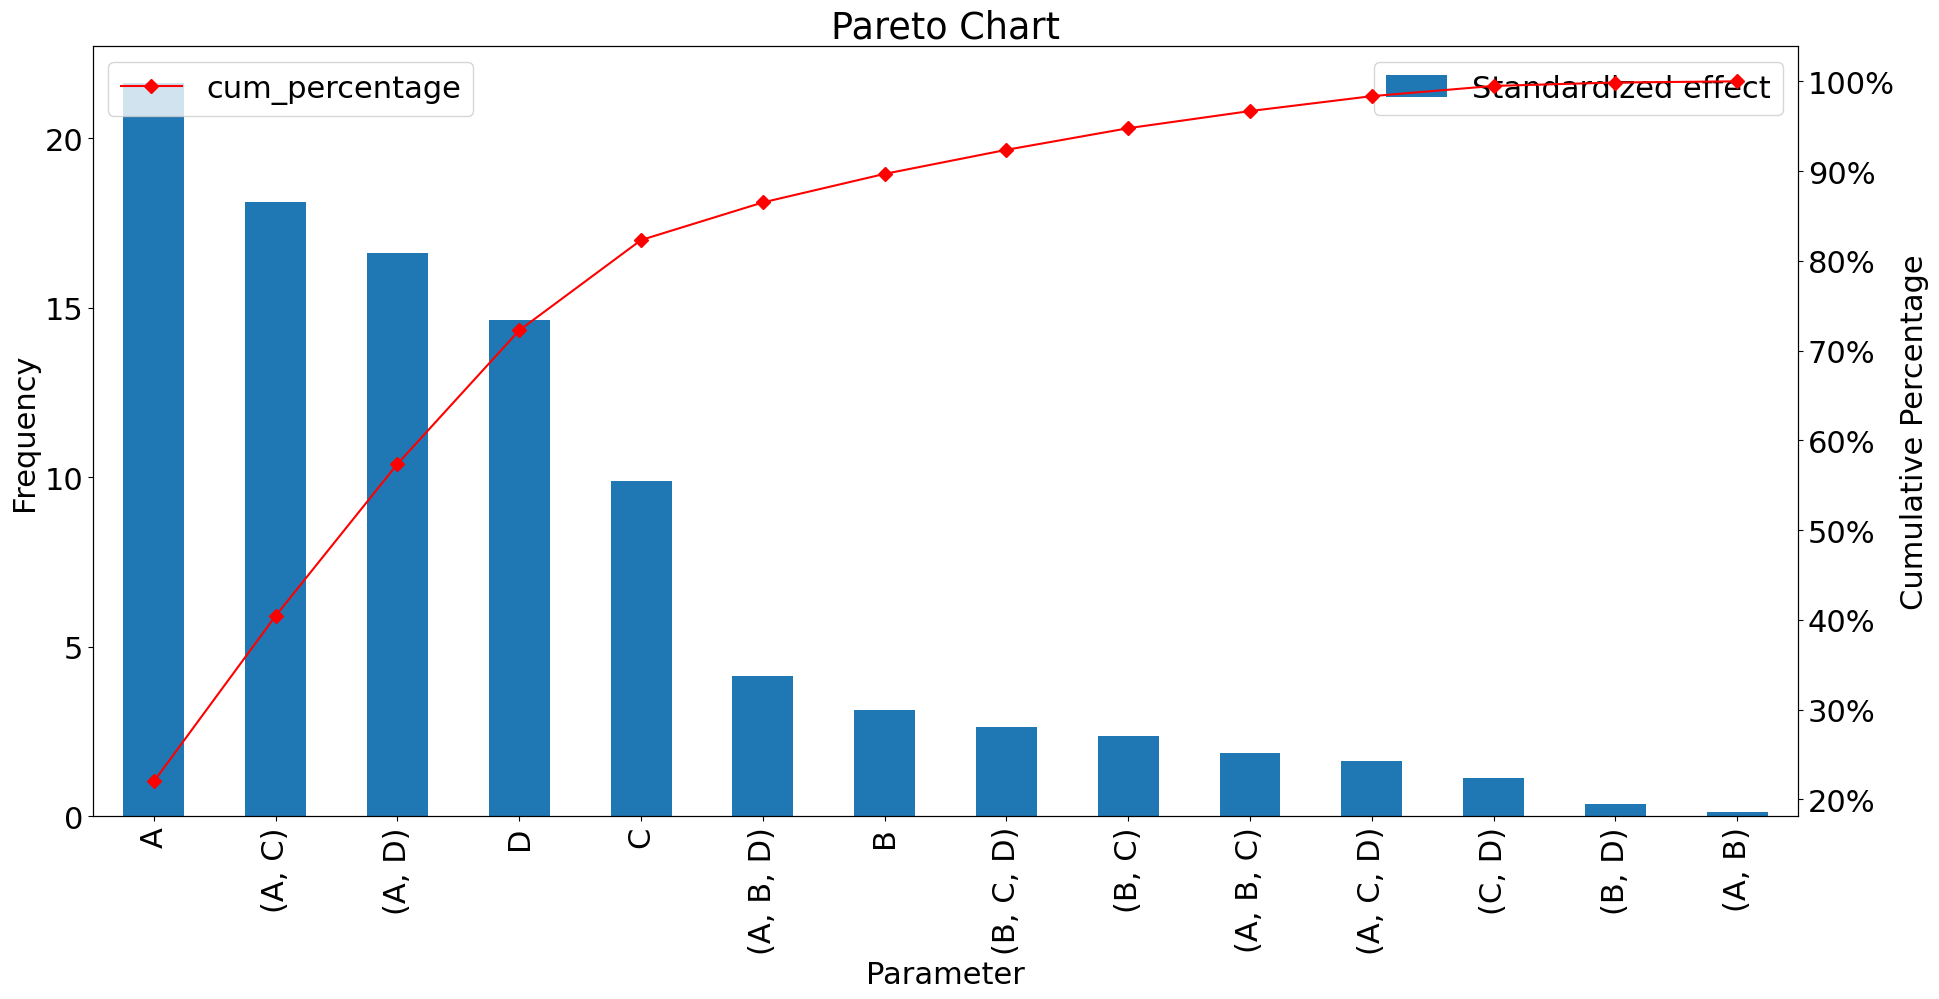

In [57]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.rcParams.update({'font.size': 22})
# Set figure and axis
fig, ax = plt.subplots(figsize=(22,10))

# Plot bars (i.e. frequencies)
ax.set_title("Pareto Chart")
ax.set_xlabel("Parameter")
ax.set_ylabel("Frequency");
effects_df.plot.bar(y='Standardized effect', ax=ax)
#ax.axhline(2.06, color="orange", linestyle="dashed")     ###We do not have a given standard deviation 

# Second y axis (i.e. cumulative percentage)
ax2 = ax.twinx()
#ax2.plot(effects_df.index, effects_df["cum_percentage"], color="red", marker="D", ms=7)
effects_df.plot(y="cum_percentage", color="red", marker="D", ms=7, ax=ax2)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel("Cumulative Percentage");

Paretoshart shows that A, A-C, A-D, D and C are the most important. 

In [58]:
#List of the effects with the sign to use for the probplot

effects=[] #creates an empty pd.DataFrame({})
indexes=[]
for i,k in enumerate(main_effects.keys()):
    effects.append(main_effects[k])
    indexes.append(k)
for i,k in enumerate(twoway_effects.keys()):
    effects.append(twoway_effects[k])
    indexes.append(k)
for i,k in enumerate(threeway_effects.keys()):
    effects.append(threeway_effects[k])
    indexes.append(k)    
    
effects_df_withsign=pd.DataFrame({"Standardized effect":effects})

# reset the indexes
effects_df_withsign.index=indexes
# Sort values in descending order
effects_df_withsign = effects_df_withsign.sort_values(by='Standardized effect', ascending=False)
# Add cumulative percentage column
effects_df_withsign["cum_percentage"] = round(effects_df_withsign["Standardized effect"].cumsum()/effects_df_withsign["Standardized effect"].sum()*100,2)

# Display data frame of the effects
effects_df_withsign

,Standardized effect,cum_percentage
A,21.625,42.82
"(A, D)",16.625,75.74
D,14.625,104.70
C,9.875,124.26
"(A, B, D)",4.125,132.43
B,3.125,138.61
"(B, C)",2.375,143.32
"(A, B, C)",1.875,147.03
"(A, B)",0.125,147.28
"(B, D)",-0.375,146.53


(array([-1.66151682, -1.18948235, -0.88997893, -0.65463235, -0.45108016,
        -0.2648058 , -0.08735875,  0.08735875,  0.2648058 ,  0.45108016,
         0.65463235,  0.88997893,  1.18948235,  1.66151682]),
 array([-18.125,  -2.625,  -1.625,  -1.125,  -0.375,   0.125,   1.875,
          2.375,   3.125,   4.125,   9.875,  14.625,  16.625,  21.625]))

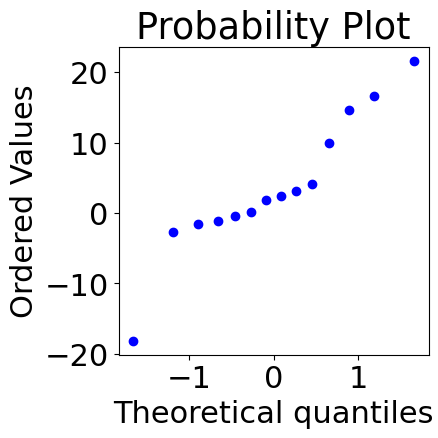

In [71]:
#Prob-plot

fig = figure(figsize=(4,4))


stats.probplot(effects_df_withsign["Standardized effect"], dist="norm", plot=plt, fit=False) #, fit=False for no fit 

#sm.qqplot(effects_df["Standardized effect"],line ='45')

In [81]:
s = "y_hat = "

s += "%0.3f "%(results['Rate'].mean())

for i,k in enumerate(main_effects.keys()):
    if(main_effects[k]<0):
        s += "%0.3f %s "%(main_effects[k]/2.0, k )
    else:
        s += " + %0.3f %s "%(main_effects[k]/2.0, k )

for i,k in enumerate(twoway_effects.keys()):
    if(twoway_effects[k]<0):
        s += " %0.3f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])         #Divide by 2 why here?
    else:
        s += " + %0.3f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])

for i,k in enumerate(threeway_effects.keys()):
    if(threeway_effects[k]<0):
        s += " %0.3f %s %s %s"%( threeway_effects[k]/2.0, k[0],k[1], k[2])
    else:
        s += "+ %0.3f %s %s %s"%( threeway_effects[k]/2.0, k[0],k[1], k[2])

for i,k in enumerate(fourway_effects.keys()):
    if(fourway_effects[k]<0):
        s += " %0.3f %s %s %s %s"%( fourway_effects[k]/2.0, k[0],k[1], k[2], k[3])
    else:
        s += " + %0.3f %s %s %s %s"%( fourway_effects[k]/2.0, k[0],k[1], k[2], k[3])


print(s)

y_hat = 70.062  + 10.812 A  + 1.562 B  + 4.938 C  + 7.312 D  + 0.062 A B -9.062 A C + 8.312 A D + 1.188 B C -0.188 B D -0.562 C D+ 0.938 A B C+ 2.062 A B D -0.812 A C D -1.312 B C D + 0.688 A B C D


Try to sort out the parameters that dont have an inpact. Do statistical analysis on the most interesting parameters from the Pareto shart. The parameters are:

A, A-C, A-D, D and C

If we do a polynomial regression with only these 5 parameters we get: 

In [79]:
#Polynomial regression with important parameters from Pareto plot

polynomial_function = smf.ols(formula='Rate ~ A + D + C + A:C + A:D', data=results).fit()   #ordinary least square

polynomial_function.summary()

/home/aleul811/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rate   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     56.74
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           5.14e-07
Time:                        15:59:00   Log-Likelihood:                -42.711
No. Observations:                  16   AIC:                             97.42
Df Residuals:                      10   BIC:                             102.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.0625      1.104     63.444      0.000      67.602      72.523
A             10.8125      1.104      9.791      0.000       8.352      13.273
D              7.3125      1.104      6.622      0.000       4.852       9.773
C              4.9375      1.104      4.471      0.001       2.477       7.398
A:C           -9.0625      1.104     -8.206      0.000     -11.523      -6.602
A:D            8.3125      1.104      7.527      0.000       5.852      10.773
==============================================================================
Omnibus:                        0.740   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.691   Jarque-Bera (JB):                0.738
Skew:                          -0.350   Prob(JB):                        0.691
Kurtosis:                       2.215   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The standard error on all the parameters are 1.104, R^2 adjusted value is 0.949. 

In [ ]:
#Annat vi kan göra: 

#Plotta enligt: /home/aleul811/DoE_Course_Material/Week_2/Workshop_5/Jupyter-notebooks/2-6factor-more_analysis.ipynb